## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

# NWS necessary imports
from __future__ import annotations

from typing import Literal

import numpy as np
import pandas as pd
import requests

# USGS necessary imports
# Import the NWIS IV Client
from hydrotools.nwis_client.iv import IVDataService

# needed to avoid errors:
import nest_asyncio
nest_asyncio.apply()

## Functions

In [3]:
# functions

# NWS gage retrieval made by NOAA github folks:
_BASE_URl = "https://api.water.noaa.gov"

def get_stageflow_product(
    identifier: str, product: Literal["observed", "forecast"]
) -> pd.DataFrame:
    url = f"{_BASE_URl}/nwps/v1/gauges/{identifier}/stageflow/{product}"
    req = requests.get(url)
    assert req.ok
    data = req.json()

    df = pd.DataFrame.from_records(data["data"], exclude=["secondary", "generatedTime"])

    df.rename(columns={"validTime": "value_time", "primary": "value"}, inplace=True)
    df["value"] = pd.to_numeric(df["value"], downcast="float")
    df["value_time"] = pd.to_datetime(df["value_time"])

    mask = np.zeros(len(df), dtype="int32")
    df["nws_lid"] = pd.Categorical.from_codes(mask, categories=[identifier])
    df["variable_name"] = pd.Categorical.from_codes(mask, categories=["stage height"])
    df["measurement_unit"] = pd.Categorical.from_codes(
        mask, categories=[data["primaryUnits"].lower()]
    )

    column_order = [
        "value_time",
        "variable_name",
        "nws_lid",
        "measurement_unit",
        "value",
    ]

    return df[column_order]



## Examples

In [26]:
# NWS at New Hope Rd

# function execution
if __name__ == "__main__":
    BatFork_NewHopeRd_df = get_stageflow_product("BFCN7", "observed")

# add datum: https://contrail.nc.gov/sensor/?time_zone=UTC&site_id=256&site=90fe39af-fba4-470f-8c70-86b9b75151a8&device_id=4&device=8a38a231-4656-4660-b0a5-0c701c58568c&bin=86400&range=Last%207%20Days&markers=false&legend=true&thresholds=true&refresh=off&show_raw=true&show_quality=true
datum_BatFork_NewHopeRd = 2074.40 # feet above   NAVD88
BatFork_NewHopeRd_df['elevation'] = BatFork_NewHopeRd_df['value'] + datum_BatFork_NewHopeRd
BatFork_NewHopeRd_df.to_csv('data/BatFork_NewHopeRd.csv')

BatFork_NewHopeRd_df

,value_time,variable_name,nws_lid,measurement_unit,value,elevation
0,2024-08-10 19:05:00+00:00,stage height,BFCN7,ft,3.68,2078.079834
1,2024-08-10 19:10:00+00:00,stage height,BFCN7,ft,1.32,2075.719971
2,2024-08-10 19:15:00+00:00,stage height,BFCN7,ft,1.67,2076.069824
3,2024-08-10 19:30:00+00:00,stage height,BFCN7,ft,7.14,2081.539795
4,2024-08-10 19:45:00+00:00,stage height,BFCN7,ft,2.86,2077.260010
...,...,...,...,...,...,...
1375,2024-09-09 13:35:00+00:00,stage height,BFCN7,ft,0.66,2075.059814
1376,2024-09-09 14:05:00+00:00,stage height,BFCN7,ft,0.67,2075.069824
1377,2024-09-09 14:35:00+00:00,stage height,BFCN7,ft,0.66,2075.059814
1378,2024-09-09 15:05:00+00:00,stage height,BFCN7,ft,0.66,2075.059814


In [20]:
# test date range
datetime_start = pd.to_datetime('2024-08-29 00:00:00+00:00')
datetime_end = pd.to_datetime('2024-09-08 00:00:00+00:00')
datetime_start_np = np.datetime64(datetime_start)
datetime_end_np = np.datetime64(datetime_end)

/var/folders/7c/v3tjh_9j0nnfj_5t4k9b4v000000gn/T/ipykernel_4792/1121794405.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  datetime_start_np = np.datetime64(datetime_start)
/var/folders/7c/v3tjh_9j0nnfj_5t4k9b4v000000gn/T/ipykernel_4792/1121794405.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  datetime_end_np = np.datetime64(datetime_end)


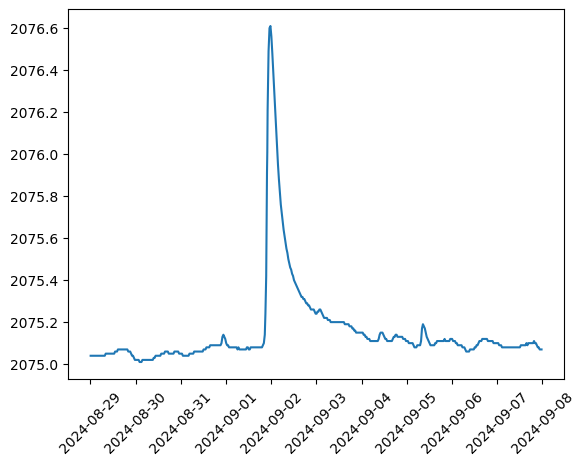

In [25]:
test_BatForkUS_df = BatFork_NewHopeRd_df[(BatFork_NewHopeRd_df['value_time'] > datetime_start) & (BatFork_NewHopeRd_df['value_time'] < datetime_end)]

plt.plot(test_BatForkUS_df.value_time, test_BatForkUS_df.elevation)
plt.xticks(rotation=45)
plt.show()

In [27]:
# USGS Mud Creek at Secondary Road (Main St)
current_date = datetime.now().date()

# Retrieve data from a single site
service = IVDataService(
    value_time_label="value_time"
)
MudCreek_SecondaryRd_df = service.get(
    sites='0344632850',
    startDT='2019-01-01',
    endDT=current_date,
    parameterCd='00065'
    )

# add datum: https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=0344632850
datum_MudCreek_SecondaryRd = 2060.98 # feet above   NAVD88

MudCreek_SecondaryRd_df['elevation'] = MudCreek_SecondaryRd_df['value'] + datum_MudCreek_SecondaryRd
MudCreek_SecondaryRd_df.to_csv('data/MudCreek_SecondaryRd.csv')

# Look at the data
MudCreek_SecondaryRd_df

,value_time,variable_name,usgs_site_code,measurement_unit,value,qualifiers,series,elevation
0,2019-06-17 15:45:00,gage height,0344632850,ft,5.69,['A'],0,2066.669922
1,2019-06-17 16:00:00,gage height,0344632850,ft,5.69,['A'],0,2066.669922
2,2019-06-17 16:15:00,gage height,0344632850,ft,5.69,['A'],0,2066.669922
3,2019-06-17 16:30:00,gage height,0344632850,ft,5.69,['A'],0,2066.669922
4,2019-06-17 16:45:00,gage height,0344632850,ft,5.70,['A'],0,2066.679932
...,...,...,...,...,...,...,...,...
183083,2024-09-08 23:00:00,gage height,0344632850,ft,5.32,['P'],0,2066.300049
183084,2024-09-08 23:15:00,gage height,0344632850,ft,5.31,['P'],0,2066.290039
183085,2024-09-08 23:30:00,gage height,0344632850,ft,5.31,['P'],0,2066.290039
183086,2024-09-08 23:45:00,gage height,0344632850,ft,5.31,['P'],0,2066.290039


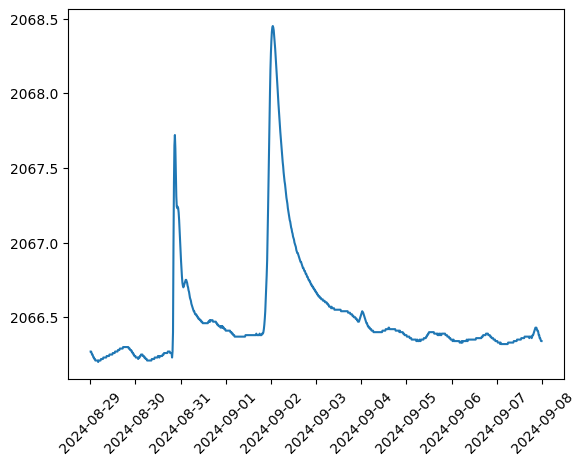

In [23]:
test_MudCreekDS_df = MudCreek_SecondaryRd_df[(MudCreek_SecondaryRd_df['value_time'] > datetime_start_np) & (MudCreek_SecondaryRd_df['value_time'] < datetime_end_np)]

plt.plot(test_MudCreekDS_df.value_time, test_MudCreekDS_df.elevation)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# precipitation
